In [2]:
import os
import yaml
import cv2
from PIL import Image
import zipfile
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from torchview import draw_graph


import warnings


In [3]:

def dump(value, filename):
    joblib.dump(value = value, filename = filename)

def load(filename):
    return joblib.load(filename = filename)


def weight_init(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

def device_init(device = "mps"):
    if device == "mps":
        return torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    elif device == "cuda":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    else:
        return torch.device("cpu")

In [4]:
def params():
    with open("../../config.yml", "r") as file:
        return yaml.safe_load(file)
    
config = params()

In [5]:
class Loader:
    def __init__(self, image_path = None, image_size = 256, batch_size = 1, split_size = 0.25):
        self.image_path = image_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.split_size = split_size

        self.X = []
        self.y = []

    def image_transforms(self):
        return transforms.Compose(
            [
                transforms.Resize((self.image_size, self.image_size), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.RandomCrop((self.image_size, self.image_size)),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
    def image_splits(self, **kwargs):
        return train_test_split(
            kwargs["X"],
            kwargs["y"],
            test_size = self.split_size,
            random_state = 42
            )

    def unzip_folder(self):
        if os.path.exists(config["path"]["raw_path"]):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(path=config["path"]["raw_path"])
        else:
            raise Exception("Unable to find the zip file".capitalize())

    def extract_features(self):
        if os.path.exists(config["path"]["raw_path"]):
            self.directory = os.path.join(config["path"]["raw_path"], "dataset")
            self.images = os.path.join(self.directory, os.listdir(self.directory)[0])
            self.masks = os.path.join(self.directory, os.listdir(self.directory)[1])

            for image in tqdm(os.listdir(self.images)):
                for mask in os.listdir(self.masks):
                    image_base_name = image.split(".")[0]
                    masks_base_name = mask.split(".")[0]

                    if image_base_name == masks_base_name:

                        X = cv2.imread(os.path.join(self.images, image))
                        X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
                        y = cv2.imread(os.path.join(self.masks, mask))
                        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)

                        self.X.append(self.image_transforms()(Image.fromarray(X)))
                        self.y.append(self.image_transforms()(Image.fromarray(y)))

            X_train, X_test, y_train, y_test = self.image_splits(X=self.X, y=self.y)

            return {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test,
                "X": self.X,
                "y": self.y,
            }

        else:
            raise Exception("Unable to find the zip file".capitalize()) 

    def create_dataloader(self):
        dataset = self.extract_features()

        if os.path.exists(config["path"]["processed_path"]):
            dataloader = DataLoader(
                dataset=list(zip(dataset["X"], dataset["y"])),
                batch_size=self.batch_size*16, shuffle=True)

            train_dataloader = DataLoader(
                dataset=list(zip(dataset["X_train"], dataset["y_train"])),
                batch_size=self.batch_size, shuffle=True)

            test_dataloader = DataLoader(
                dataset=list(zip(dataset["X_test"], dataset["y_test"])),
                batch_size=self.batch_size*4, shuffle=True)

            dump(value=dataloader, filename=os.path.join(config["path"]["processed_path"], "dataloader.pkl"))
            dump(value=train_dataloader, filename=os.path.join(config["path"]["processed_path"], "train_dataloader.pkl"))
            dump(value=test_dataloader, filename=os.path.join(config["path"]["processed_path"], "test_dataloader.pkl"))

        else:
            raise Exception("Unable to create the dataloader file".capitalize())

    @staticmethod
    def plot_images():
        if os.path.exists(config["path"]["processed_path"]):
            test_dataloader = load(os.path.join(config["path"]["processed_path"], "dataloader.pkl"))

            data, label = next(iter(test_dataloader))

            plt.figure(figsize=(25, 15))

            for index, image in enumerate(data):
                X = image.permute(1, 2, 0).numpy()
                y = label[index].permute(1, 2, 0).numpy()

                X = (X - X.min())/(X.max() - X.min())
                y = (y - y.min())/(y.max() - y.min())

                plt.subplot(2 * 4, 2 * 4, 2 * index + 1)
                plt.imshow(X)
                plt.title("X")
                plt.axis("off")

                plt.subplot(2 * 4, 2 * 4, 2 * index + 2)
                plt.imshow(y, cmap="gray")
                plt.title("y")
                plt.axis("off")

            plt.savefig(os.path.join(config["path"]["files_path"], "images.png"))

            plt.tight_layout()
            plt.show()

        else:
            raise Exception("Unable to open the dataloader file".capitalize())

    @staticmethod
    def dataset_details():
        if os.path.exists(config["path"]["processed_path"]):
            dataloader = load(filename=os.path.join(config["path"]["processed_path"], "dataloader.pkl"))
            train_dataloader = load(filename=os.path.join(config["path"]["processed_path"], "train_dataloader.pkl"))
            test_dataloader = load(filename=os.path.join(config["path"]["processed_path"], "test_dataloader.pkl"))

            train_image, _ = next(iter(train_dataloader))
            test_image, _ = next(iter(test_dataloader))

            pd.DataFrame(
                {
                    "total_images": str(sum(image.size(0) for image, _ in dataloader)),
                    "train_data": str(sum(image.size(0) for image, _ in train_dataloader)),
                    "test_data": str(sum(image.size(0) for image, _ in test_dataloader)),
                    "train_data_shape": str(train_image.size()),
                    "test_data_shape": str(test_image.size()),
                },
                index=["Quantity"],
            ).T.to_csv(os.path.join(config["path"]["files_path"], "dataset_details.csv"))

        else:
            raise Exception("Unable to find the dataloader file".capitalize())

In [6]:
loader = Loader(image_path="../../data/raw/dataset.zip", split_size=0.50)

loader.unzip_folder()
loader.create_dataloader()

100%|██████████| 18/18 [00:00<00:00, 58.41it/s]


In [7]:
loader.dataset_details()

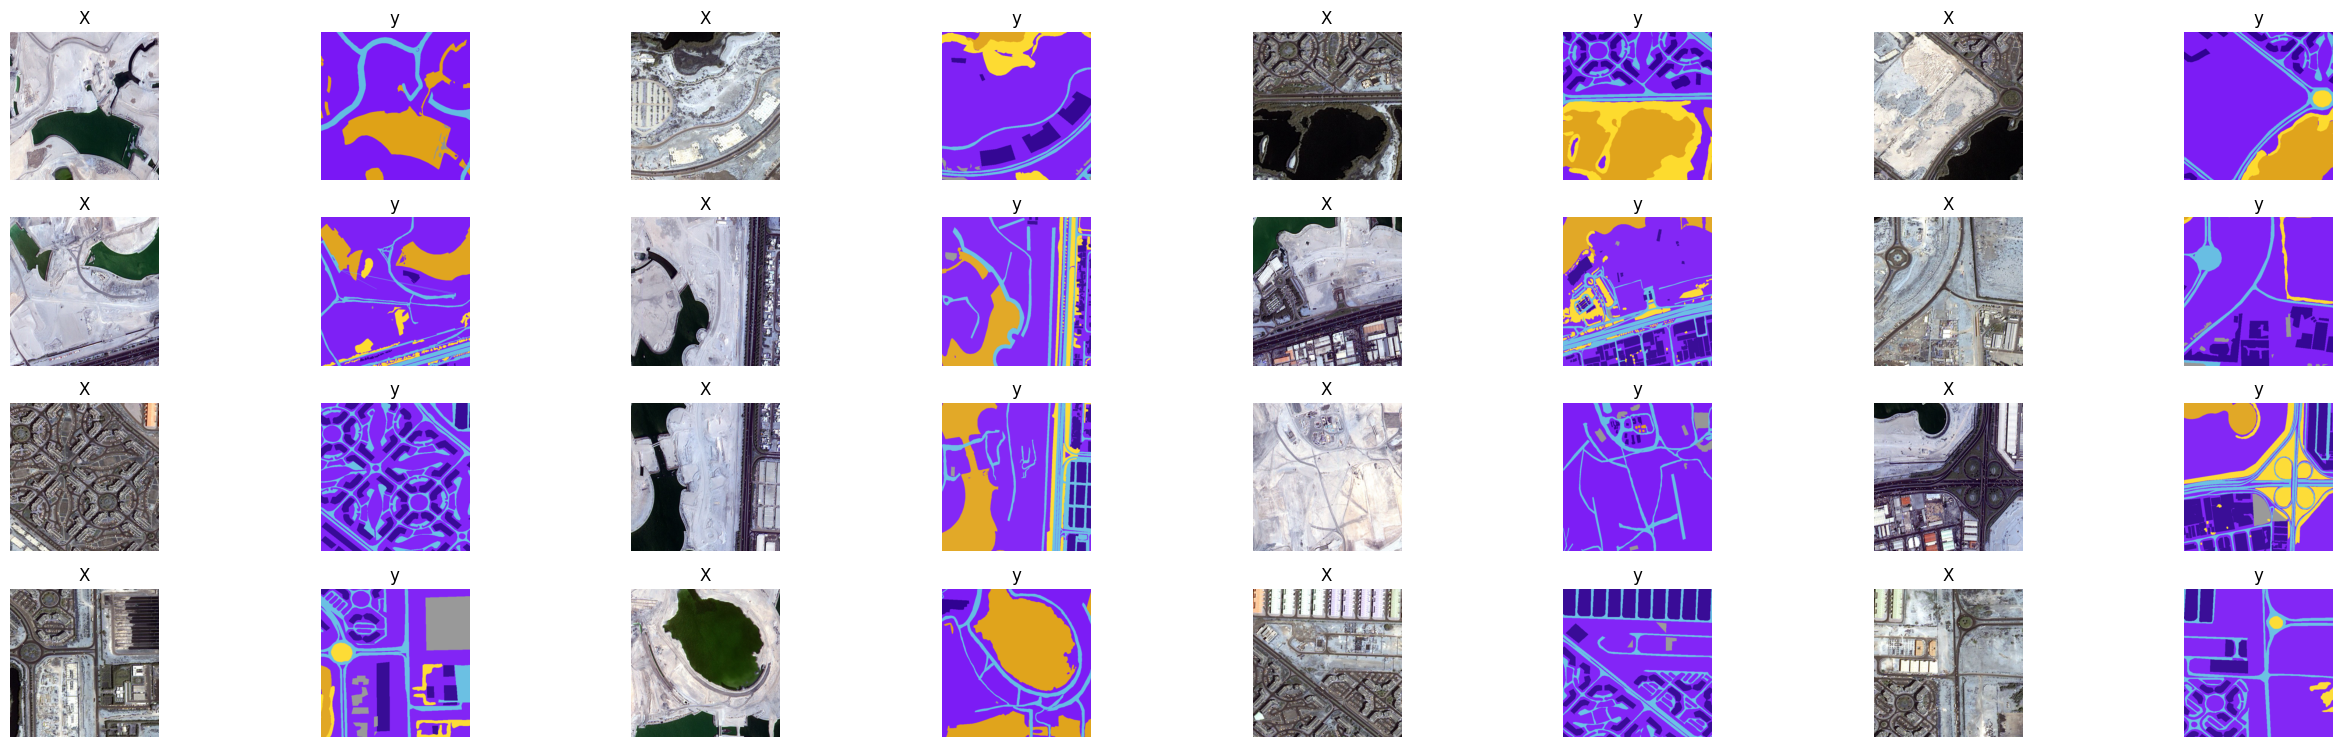

In [8]:
loader.plot_images()

#### Generator

In [9]:
class InputBlock(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 64):
        super(InputBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.kernel = 7
        self.stride = 1
        self.padding = 3
        
        self.layers = OrderedDict()
        
        self.input = self.block()
        
    
    def block(self):
        
        self.layers["conv"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel,
            stride=self.stride,
            padding=self.padding,
            padding_mode="reflect"
            )
        
        self.layers["instance_norm"] = nn.InstanceNorm2d(
            num_features=self.out_channels)
        
        self.layers["ReLU"] = nn.ReLU(inplace=True)
        
        return nn.Sequential(self.layers)
    
    def forward(self, x):
        if x is not None:
            return self.input(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())

In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_channels = 64):
        super(DownBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels * 2
        
        self.kernel = 3
        self.stride = 2
        self.padding = 1
        
        self.layers = OrderedDict()
        
        self.decoder = self.down_block()
        
    
    def down_block(self):
        
        self.layers["conv"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel,
            stride=self.stride,
            padding=self.padding
            )
        
        self.layers["instance_norm"] = nn.InstanceNorm2d(
            num_features=self.out_channels)
        
        self.layers["ReLU"] = nn.ReLU(inplace=True)
        
        return nn.Sequential(self.layers)
        
    
    def forward(self, x):
        if x is not None:
            return self.decoder(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())

if __name__ == "__main__":
    in_channels = 64
    layers = []
    for _ in range(2):
        layers.append(DownBlock(in_channels=in_channels))
        in_channels *= 2

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels = 256):
        super(ResidualBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = in_channels
        
        self.kernel = 3
        self.stride = 1
        self.padding = 1
        
        self.layers = OrderedDict()
        
        self.residual = self.residual_block()
        
    
    def residual_block(self):
        
        for idx in range(2):
            self.layers["conv_{}".format(idx)] = nn.Conv2d(
                in_channels=self.in_channels,
                out_channels=self.out_channels,
                kernel_size=self.kernel,
                stride=self.stride,
                padding=self.padding
        
            )
            self.layers["instance_norm_{}".format(idx)] = nn.InstanceNorm2d(
                num_features=self.out_channels
                )
            
            if idx%2 == 0:
                self.layers["ReLU_{}".format(idx)] = nn.ReLU(inplace=True)
                
        return nn.Sequential(self.layers)
        
        
    def forward(self, x):
        if x is not None:
            return x + self.residual(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())
        
        
if __name__ == "__main__":
    in_channels = 256
    layers = []
    
    model = nn.Sequential(*[ResidualBlock(in_channels=in_channels) for _ in range(9)])

In [12]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels = 256):
        super(UpsampleBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels // 2
        
        self.kernel = 3
        self.stride = 2
        self.padding = 1
        
        self.layers = OrderedDict()
        
        self.encoder = self.up_block()
        
    def up_block(self):
        
        self.layers["conv"] = nn.ConvTranspose2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel,
            stride=self.stride,
            padding=self.padding,
            output_padding=self.padding
        )
        
        self.layers["instance_norm"] = nn.InstanceNorm2d(
            num_features=self.out_channels
        )
        
        self.layers["ReLU"] = nn.ReLU(inplace=True)
        
        return nn.Sequential(self.layers)
    
    def forward(self, x):
        if x is not None:
            return self.encoder(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())


if __name__ == "__main__":
    in_channels = 256
    layers = []

    for _ in range(2):
        layers.append(UpsampleBlock(in_channels=in_channels))
        in_channels //= 2
        
    model = nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    def __init__(self, in_channels = 3):
        super(Generator, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = 64
        self.kernel = 7
        self.stride = 1
        self.padding = 3
        self.num_repetitive = 9
        
        self.layers = []
        
        self.layers.append(InputBlock(
            in_channels=self.in_channels, out_channels=self.out_channels))
        
        for _ in range(2):
            self.layers.append(DownBlock(in_channels=self.out_channels))
            self.out_channels *= 2
            
        for _ in range(self.num_repetitive):
            self.layers.append(ResidualBlock(in_channels=self.out_channels))
            
        for _ in range(2):
            self.layers.append(UpsampleBlock(in_channels=self.out_channels))
            self.out_channels //= 2
        
            
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(
                    in_channels=self.out_channels,
                    out_channels=3,
                    kernel_size=self.kernel,
                    stride=self.stride,
                    padding=self.padding,
                    padding_mode="reflect"
                    ),
                
                nn.Tanh()
            )
        )
        
        self.model = nn.Sequential(*self.layers)
            
    def forward(self, x):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())

In [14]:
if __name__ == "__main__":
    netG = Generator(in_channels=3)
    summary(model=netG, input_size=(3, 256, 256), batch_size=1)  # Show the model summary
    draw_graph(model=netG, input_data=torch.randn(1, 3, 256, 256)).visual_graph # Check the model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           9,472
    InstanceNorm2d-2          [1, 64, 256, 256]               0
              ReLU-3          [1, 64, 256, 256]               0
        InputBlock-4          [1, 64, 256, 256]               0
            Conv2d-5         [1, 128, 128, 128]          73,856
    InstanceNorm2d-6         [1, 128, 128, 128]               0
              ReLU-7         [1, 128, 128, 128]               0
         DownBlock-8         [1, 128, 128, 128]               0
            Conv2d-9           [1, 256, 64, 64]         295,168
   InstanceNorm2d-10           [1, 256, 64, 64]               0
             ReLU-11           [1, 256, 64, 64]               0
        DownBlock-12           [1, 256, 64, 64]               0
           Conv2d-13           [1, 256, 64, 64]         590,080
   InstanceNorm2d-14           [1, 256,

#### Discriminator

In [15]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 64, kernel = 4, stride = 2, padding = 1, is_instance_norm = False, is_lr = True):
        super(DiscriminatorBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.use_norm = is_instance_norm
        self.use_lr = is_lr
        
        self.model = self.block()
        
    
    def block(self):
        layers = OrderedDict()
        
        layers["conv"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel,
            stride=self.stride,
            padding=self.padding
            )
        
        if self.use_norm:
            layers["instance_norm"] = nn.InstanceNorm2d(
                num_features=self.out_channels
            )
        
        if self.use_lr:
            layers["LeakyReLU"] = nn.LeakyReLU(
                negative_slope=0.2, inplace=True)
        
        return nn.Sequential(layers)
        
    
    def forward(self, x):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3):
        super(Discriminator, self).__init__()

        self.layers = []
        self.in_channels = in_channels
        self.out_channels = 64
        self.kernel = 4
        self.stride = 2
        self.padding = 1

        for idx in range(3):
            self.layers.append(DiscriminatorBlock(
                in_channels=self.in_channels,
                out_channels=self.out_channels,
                kernel=self.kernel,
                stride=self.stride,
                padding=self.padding,
                is_instance_norm= False if idx == 0 else True
                ))
            
            self.in_channels = self.out_channels
            self.out_channels *= 2

        for idx in range(2):
            self.layers.append(
                DiscriminatorBlock(
                    in_channels=self.in_channels,
                    out_channels=self.out_channels,
                    kernel=self.kernel,
                    stride=self.stride // 2,
                    padding=self.padding,
                    is_instance_norm=True if idx == 0 else False,
                    is_lr=True if idx == 0 else False,
                )
            )
            self.in_channels = self.out_channels
            self.out_channels //= self.out_channels
            
            
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Input to the model cannot be empty".capitalize())


if __name__ == "__main__":
    netD = Discriminator(in_channels=3)
    assert netD(torch.randn(1, 3, 256, 256)).size() == (1, 1, 30, 30)
    
    print(summary(model=netD, input_size=(3, 256, 256), batch_size=1))
    draw_graph(model=netD, input_data=torch.randn(1, 3, 256, 256)).visual_graph # Check the model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 128, 128]           3,136
         LeakyReLU-2          [1, 64, 128, 128]               0
DiscriminatorBlock-3          [1, 64, 128, 128]               0
            Conv2d-4           [1, 128, 64, 64]         131,200
    InstanceNorm2d-5           [1, 128, 64, 64]               0
         LeakyReLU-6           [1, 128, 64, 64]               0
DiscriminatorBlock-7           [1, 128, 64, 64]               0
            Conv2d-8           [1, 256, 32, 32]         524,544
    InstanceNorm2d-9           [1, 256, 32, 32]               0
        LeakyReLU-10           [1, 256, 32, 32]               0
DiscriminatorBlock-11           [1, 256, 32, 32]               0
           Conv2d-12           [1, 512, 31, 31]       2,097,664
   InstanceNorm2d-13           [1, 512, 31, 31]               0
        LeakyReLU-14           [1, 512

#### Define the Loss

In [17]:
class GANLoss(nn.Module):
    def __init__(self, reduction = "mean"):
        super(GANLoss, self).__init__()
        
        self.reduction = reduction
        self.loss = nn.MSELoss(reduction=self.reduction)
        
    def forward(self, predicted, actual):
        if type(predicted) == torch.Tensor and type(actual) == torch.Tensor:
            return self.loss(predicted, actual)
        
        else:
            raise Exception("Input to the model cannot be empty".capitalize())
        

if __name__ == "__main__":
    gan_loss = GANLoss()
    
    predicted = torch.randn(1, 1, 30, 30)
    actual = torch.randn(1, 1, 30, 30)
    
    print(gan_loss(predicted=predicted, actual=actual))

tensor(1.8030)


In [18]:
class CycleConsistencyLoss(nn.Module):
    def __init__(self, reduction = "mean"):
        super(CycleConsistencyLoss, self).__init__()
        
        self.reduction = reduction
        self.loss = nn.L1Loss(reduction=self.reduction)
        
    def forward(self, reconstructed, real):
        if type(reconstructed) == torch.Tensor and type(real) == torch.Tensor:
            return self.loss(reconstructed, real)
        
        else:
            raise Exception("Input to the model cannot be empty".capitalize())
        
if __name__ == "__main__":
    cycle_loss = CycleConsistencyLoss()
    
    reconstructed = torch.randn(1, 3, 256, 256)
    real = torch.randn(1, 3, 256, 256)
    
    print(cycle_loss(reconstructed=reconstructed, real=real))

tensor(1.1294)


In [50]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def load_dataloader():
    if os.path.exists(params()["path"]["processed_path"]):
        train_dataloader = load(
            filename=os.path.join(
                params()["path"]["processed_path"], "train_dataloader.pkl"
            )
        )
        test_dataloader = load(
            filename=os.path.join(
                params()["path"]["processed_path"], "test_dataloader.pkl"
            )
        )

        return {
            "train_dataloader": train_dataloader,
            "test_dataloader": test_dataloader,
        }


def helper(**kwargs):

    in_channels = kwargs["in_channels"]
    lr = kwargs["lr"]
    adam = kwargs["adam"]
    SGD = kwargs["SGD"]
    lr_scheduler = kwargs["lr_scheduler"]

    netG_XtoY = Generator(in_channels=in_channels)
    netG_YtoX = Generator(in_channels=in_channels)

    netD_X = Discriminator(in_channels=in_channels)
    netD_Y = Discriminator(in_channels=in_channels)

    netG_XtoY.apply(weight_init)
    netG_YtoX.apply(weight_init)

    netD_X.apply(weight_init)
    netD_Y.apply(weight_init)

    if adam:
        optimizer_G = optim.Adam(
            params=list(netG_XtoY.parameters()) + list(netG_YtoX.parameters()),
            lr=lr,
            betas=(params()["model"]["beta1"], params()["model"]["beta2"]),
        )
        optimizer_D_X = optim.Adam(
            params=netD_X.parameters(),
            lr=lr,
            betas=(params()["model"]["beta1"], params()["model"]["beta2"]),
        )
        optimizer_D_Y = optim.Adam(
            params=netD_Y.parameters(),
            lr=lr,
            betas=(params()["model"]["beta1"], params()["model"]["beta2"]),
        )

    if SGD:
        optimizer_G = optim.SGD(
            params=list(netG_XtoY.parameters()) + list(netG_YtoX.parameters()),
            lr=lr,
            momentum=params()["model"]["momentum"],
        )
        optimizer_D_X = optim.SGD(
            params=netD_X.parameters(), lr=lr, momentum=params()["model"]["momentum"]
        )
        optimizer_D_Y = optim.SGD(
            params=netD_Y.parameters(), lr=lr, momentum=params()["model"]["momentum"]
        )

    try:
        dataloader = load_dataloader()

    except Exception as e:
        print("The exception is: %s" % e)

    adversarial_loss = GANLoss(reduction="mean")
    cycle_consistency_loss = CycleConsistencyLoss(reduction="mean")

    return {
        "netG_XtoY": netG_XtoY,
        "netG_YtoX": netG_YtoX,
        "netD_X": netD_X,
        "netD_Y": netD_Y,
        "optimizer_G": optimizer_G,
        "optimizer_D_X": optimizer_D_X,
        "optimizer_D_Y": optimizer_D_Y,
        "train_dataloader": dataloader["train_dataloader"],
        "test_dataloader": dataloader["test_dataloader"],
        "adversarial_loss": adversarial_loss,
        "cycle_consistency_loss": cycle_consistency_loss,
    }


if __name__ == "__main__":
    init = helper(
        in_channels = 3,
        lr = 0.0002,
        adam = True,
        SGD = False,
        lr_scheduler = True
    )
    
    # print(init["netG_XtoY"])
    # print(init["netG_YtoX"])
    # print(init["netD_X"])
    # print(init["netD_Y"])
    # print(init["optimizer_G"])
    # print(init["optimizer_D_X"])
    # print(init["optimizer_D_Y"])
    # print(init["schedulerG"])
    # print(init["scheduler_D_X"])
    # print(init["scheduler_D_Y"])
    # print(init["train_dataloader"])
    # print(init["test_dataloader"])
    # print(init["adversarial_loss"])
    # print(init["cycle_consistency_loss"])

In [51]:
import numpy as np

class Trainer:

    def __init__(
        self,
        in_channels=3,
        epochs=1000,
        lr=0.0002,
        device="mps",
        adam=True,
        SGD=False,
        lr_scheduler = False,
        is_display=True,
    ):
        self.in_channels = in_channels
        self.epochs = epochs
        self.lr = lr
        self.device = device
        self.adam = adam
        self.SGD = SGD
        self.lr_scheduler = lr_scheduler
        self.is_display = is_display

        self.total_D_X_loss = []
        self.total_D_y_loss = []
        self.total_G_losses = []

        self.device = device_init(device=self.device)
        self.config = params()
        self.loss = float('inf')

        init = helper(
            in_channels=self.in_channels,
            lr=self.lr,
            adam=self.adam,
            SGD=self.SGD,
            lr_scheduler=self.lr_scheduler
        )

        self.netG_XtoY = init["netG_XtoY"].to(self.device)
        self.netG_YtoX = init["netG_YtoX"].to(self.device)

        self.netD_X = init["netD_X"].to(self.device)
        self.netD_Y = init["netD_Y"].to(self.device)

        self.optimizer_G = init["optimizer_G"]
        self.optimizer_D_X = init["optimizer_D_X"]
        self.optimizer_D_Y = init["optimizer_D_Y"]

        self.train_dataloader = init["train_dataloader"]
        self.test_dataloader = init["test_dataloader"]

        self.adversarial_loss = init["adversarial_loss"]
        self.cycle_consistency_loss = init["cycle_consistency_loss"]

    def l1(self, model):
        if model is not None:
            return self.config["model"]["reg_lambda"] * sum(torch.norm(params, 1) for params in model.parameters())
        else:
            raise ValueError("Model is not defined")

    def l2(self, model):
        if model is not None:
            return self.config["model"]["reg_lambda"] * sum(torch.norm(params, 2) for params in model.parameters())

    def elastic_net(self, model):
        if model is not None:
            l1 = self.l1(model = model)
            l2 = self.l2(model = model)

            return self.config["model"]["reg_lambda"] * (l1 + l2)

    def saved_checkpoints_netG_XtoY(self, **kwargs):
        if os.path.exists(self.config["path"]["train_netG_XtoY"]):

            torch.save(
                self.netG_XtoY.state_dict(),
                os.path.join(self.config["path"]["train_netG_XtoY"], "netG_XtoY_{}.pth".format(kwargs["epoch"])),
            )
        else:
            raise FileNotFoundError(
                "Path is not found to save checkpoints(netG_XtoY)".capitalize()
            )

    def saved_checkpoints_netG_YtoX(self, **kwargs):
        if os.path.exists(self.config["path"]["train_netG_YtoX"]):

            torch.save(
                self.netG_YtoX.state_dict(),
                os.path.join(self.config["path"]["train_netG_YtoX"], "netG_YtoX_{}.pth".format(kwargs["epoch"])),
            )
        else:
            raise FileNotFoundError("Path is not found to save checkpoints(netG_YtoX)".capitalize())

    def update_generator(self, **kwargs):
        self.optimizer_G.zero_grad()

        predicted_fake_y = self.netD_Y(kwargs["fake_y"])
        loss_fake_y = self.adversarial_loss(
            predicted_fake_y, torch.ones_like(predicted_fake_y)
        )
        reconstructed_x = self.netG_YtoX(kwargs["fake_y"])
        loss_cycle_x = self.cycle_consistency_loss(
            reconstructed_x, kwargs["real_x"])

        predicted_fake_x = self.netD_X(kwargs["fake_x"])
        loss_fake_x = self.adversarial_loss(
            predicted_fake_x, torch.ones_like(predicted_fake_x)
        )
        reconstructed_y = self.netG_XtoY(kwargs["fake_x"])
        loss_cycle_y = self.cycle_consistency_loss(reconstructed_y, kwargs["real_y"])

        total_G_loss =loss_fake_y + loss_fake_x + 10 * loss_cycle_x + 10 * loss_cycle_y

        total_G_loss.backward(retain_graph=True)
        self.optimizer_G.step()

        return total_G_loss.item()

    def update_netD_X(self, **kwargs):
        self.optimizer_D_X.zero_grad()

        predicted_real_x = self.netD_X(kwargs["real_x"])
        predicted_fake_x = self.netD_X(kwargs["fake_x"])

        loss_real_x = self.adversarial_loss(predicted_real_x, torch.ones_like(predicted_real_x))
        loss_fake_x = self.adversarial_loss(predicted_fake_x, torch.zeros_like(predicted_fake_x))

        total_D_X_loss = (loss_real_x + loss_fake_x) * 0.5

        total_D_X_loss.backward(retain_graph=True)
        self.optimizer_D_X.step()

        return total_D_X_loss.item()

    def update_netD_Y(self, **kwargs):
        self.optimizer_D_Y.zero_grad()

        predicted_real_y = self.netD_Y(kwargs["real_y"])
        predicted_fake_y = self.netD_Y(kwargs["fake_y"])

        loss_real_y = self.adversarial_loss(
            predicted_real_y, torch.ones_like(predicted_real_y))
        loss_fake_y = self.adversarial_loss(
            predicted_fake_y, torch.zeros_like(predicted_fake_y)
        )

        total_D_Y_loss = (loss_real_y + loss_fake_y) * 0.5

        total_D_Y_loss.backward(retain_graph=True)
        self.optimizer_D_Y.step()

        return total_D_Y_loss.item()

    def show_progress(self, **kwargs):
        if self.is_display:
            print("Epochs - [{}/{}] - G_loss: {:.4f} - D_X_loss: {:.4f} - D_Y_loss: {:.4f}".format(
                kwargs["epoch"],
                np.mean(kwargs["epochs"]),
                np.mean(kwargs["G_losses"]),
                np.mean(kwargs["D_X_loss"]),
                np.mean(kwargs["D_y_loss"]),
            ))
        else:
            print("Epochs - [{}/{}] is completed".format(kwargs["epoch"], kwargs["epochs"]))

    def saved_trained_best_model(self, **kwargs):
        if os.path.exists(self.config["path"]["best_model"]):
            if self.loss > kwargs["loss"]:
                self.loss = kwargs["loss"]
                torch.save(
                    {
                        "netG_XtoY": self.netG_XtoY.state_dict(),
                        "netG_YtoX": self.netG_YtoX.state_dict(),
                        "loss": kwargs["loss"],
                        "epoch": kwargs["epoch"],
                    },
                    os.path.join(self.config["path"]["best_model"], "best_model.pth"),
                )
        else:
            raise FileNotFoundError(
                "Path is not found to save checkpoints(best_model)".capitalize()
            )

    def saved_trained_images(self, **kwargs):
        data, label = next(iter(self.test_dataloader))

        XtoY = self.netG_XtoY(data.to(self.device))
        YtoX = self.netG_YtoX(label.to(self.device))

        save_image(
            XtoY,
            os.path.join(
                self.config["path"]["train_results"],
                "XtoY_{}.png".format(kwargs["epoch"] + 1),
            ),
            nrow=2,
            normalize=True,
        )

        save_image(
            YtoX,
            os.path.join(
                self.config["path"]["train_results"],
                "YtoX_{}.png".format(kwargs["epoch"] + 1),
            ),
            nrow=2,
            normalize=True,
        )
        
    def saved_model_history(self, **kwargs):
        if os.path.exists(self.config["path"]["model_history"]):

            pd.DataFrame(
                {
                    "G_loss": kwargs["G_losses"],
                    "D_X_loss": kwargs["D_X_loss"],
                    "D_Y_loss": kwargs["D_Y_loss"],
                }
            ).to_csv(os.path.join(self.config["path"]["model_history"], "model_history.csv"), index=True)

    def train(self):
        warnings.filterwarnings('ignore')

        for epoch in tqdm(range(self.epochs)):
            D_X_loss = []
            D_y_loss = []
            G_losses = []

            for _, (X, y) in enumerate(self.train_dataloader):
                X = X.to(self.device)
                y = y.to(self.device)

                fake_y = self.netG_XtoY(X)
                fake_x = self.netG_YtoX(y)

                D_y_loss.append(self.update_netD_Y(fake_y=fake_y, real_y=y))
                D_X_loss.append(self.update_netD_X(fake_x=fake_x, real_x=X))

                G_losses.append(self.update_generator(fake_x=fake_x, fake_y=fake_y, real_x=X, real_y=y))

            try:
                self.show_progress(epoch=epoch+1, epochs = self.epochs, D_X_loss=D_X_loss, D_y_loss=D_y_loss, G_losses=G_losses)

            except Exception as e:
                print("The exception is {}".format(e))

            else:
                self.saved_checkpoints_netG_XtoY(epoch=epoch+1)
                self.saved_checkpoints_netG_YtoX(epoch=epoch+1)
                self.saved_trained_best_model(epoch=epoch+1, loss=np.mean(G_losses))

                if epoch%100:
                    
                    self.saved_trained_images(epoch=epoch+1)

                self.total_G_losses.append(np.mean(G_losses))
                self.total_D_X_loss.append(np.mean(D_X_loss))
                self.total_D_y_loss.append(np.mean(D_y_loss))

            finally:
                pass

        if os.path.exists(self.config["path"]["train_metrics"]):
            
            dump(value=self.total_G_losses, filename=os.path.join(self.config["path"]["train_metrics"], "G_losses.pkl"))
            dump(value=self.total_D_X_loss, filename=os.path.join(self.config["path"]["train_metrics"], "D_X_loss.pkl"))
            dump(value=self.total_D_y_loss, filename=os.path.join(self.config["path"]["train_metrics"], "D_y_loss.pkl"))
            
            try:
                self.saved_model_history(G_losses=self.total_G_losses, D_X_loss=self.total_D_X_loss, D_Y_loss=self.total_D_y_loss)
                
            except Exception as e:
                print("The exception is {}".format(e))
        else:
            os.mkdir(self.config["path"]["train_metrics"])

    @staticmethod
    def plot_history():
        pass

In [52]:
trainer = Trainer(epochs=2, is_display=True)

In [53]:
trainer.train()

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs - [1/2.0] - G_loss: 19.7899 - D_X_loss: 2.5524 - D_Y_loss: 2.6444


 50%|█████     | 1/2 [00:08<00:08,  8.80s/it]

Epochs - [2/2.0] - G_loss: 15.9863 - D_X_loss: 2.2162 - D_Y_loss: 2.1935


100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


In [ ]:
XtoY = torch.load(os.path.join(config["path"]["train_netG_XtoY"], "netG_XtoY_500.pth"))
YtoX = torch.load(os.path.join(config["path"]["train_netG_YtoX"], "netG_YtoX_500.pth"))

dataloader = load(filename=os.path.join(config["path"]["processed_path"], "train_dataloader.pkl"))

data, label = next(iter(dataloader))

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

netG_XtoY = Generator(in_channels=3).to(device)
netG_YtoX = Generator(in_channels=3).to(device)

netG_XtoY.load_state_dict(XtoY)
netG_YtoX.load_state_dict(YtoX)

fake_y = netG_XtoY(data.to(device))
reconstructed_x = netG_YtoX(fake_y)

In [ ]:
Y = fake_y.squeeze().permute(1, 2, 0)
X = reconstructed_x.squeeze().permute(1, 2, 0)
real = data.squeeze().permute(1, 2, 0)

X = X.cpu().detach().numpy()
Y = Y.cpu().detach().numpy()

Y = (Y - Y.min()) / (Y.max() - Y.min())
X = (X - X.min())/(X.max() - X.min())
data = (data - data.min())/(data.max() - data.min())

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(real)
plt.title("Fake Image")

plt.subplot(1, 3, 2)
plt.imshow(Y)
plt.title("Fake Image")

plt.subplot(1, 3, 3)
plt.imshow(X)
plt.title("Reconstructed Image")

plt.show()